# **Neural Machine Translation**

### **Team Members:**

1. Monesa Thoguluva Janardhanan - 801167556<br>
2. Sai Bharadwaj Reddy Arrabelly - 801166672<br>
3. Prashanth Minkuri - 801166901

# **Introduction**

The main aim of our project is to build a Neural Machine Translation model by using Transformer model to translate Japanese sentences to English sentences.

We have followed the same approach followed in the following paper "Attention is all you need" 
https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

This paper has built a transformer model for English to German and English to French and has accquired about 41.0 BLEU score. 

We have built the same Transformer model by following the paper for Japanese to English and have succeeded in achieving the state of the art BLEU score.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **Dataset Explanation**

As a first step we used a Jaoanese English corpus from the following link for our model.

https://www.kaggle.com/team-ai/japaneseenglish-bilingual-corpus

This dataset mainly deals about traditional Japanese culture, religion, and history. As we went through the dataset it didnt have any daily life conversation or normal words that Japanese people use frequently. It was all about government offices, festivals etc. When we built our baseline model (we used seq2seq model as our basline) and ran this dataset we achieved a very low BLEU score of 4.86. When we built a transformer model and trained with this dataset, it gave us a BLEU score of 14.This made us look into more datasets and we felt if we have huge data for training the model will predict well. So we found another dataset from the following link 

https://www.manythings.org/anki/

This has a normal daily life conversation of Japanese and
we trained our model with this dataset. To our suprise we got about 61.0 BLEU score and the next step was to merge our dataset and predicted the BLEU score. This gave us 41.0 which is the state of art BLEU score.

In [ ]:
ANKI_LEXICON_PATH = '/content/drive/MyDrive/NLP/Final Project Dataset/eng_jpn.txt'
KYOTO_LEXICON_PATH = '/content/drive/MyDrive/NLP/Final Project Dataset/kyoto_lexicon.csv'

## **Hyperparamters**

The below are the Hyperparamters for our model. 
We trained our model for 100 Epoch and the rest of the hyperparamters are exactly same as that of the paper becuase we tried tweaking them but we got low BLEU score and high preplexity. 

So we moved forward with the same values of hyperparamters as given in "Attention is all you need" paper.


In [111]:
BATCH_SIZE = 20
EPOCHS = 100

D_MODEL = 512
HEADS = 8
N = 6

We are training this model on CUDA. For 100 epoch our model takes about 2 hour 30 mins or max 3 hours to train.

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
import math
import copy
from datetime import datetime
from nltk.translate.bleu_score import sentence_bleu
# from janome.tokenizer import Tokenizer

if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


## **Preprocessing**

We are using spacy library for tokenization of english and japanese language. spaCy is a free open source library for Natural Language Processing in Python. https://spacy.io/ says spaCy is the best way to prepare text for deep learning. It interoperates seamlessly with TensorFlow, PyTorch, scikit-learn, Gensim and the rest of Python's awesome AI ecosystem. With spaCy, you can easily construct linguistically sophisticated statistical models for a variety of NLP problems.
<br/>
And for Japanese language there are no spaces between the words. For example I lived in Tokyo sentence translates to 私は東京に住んでいました. Here in the above example there are no spaces between the words. But, <br/><br/>
私 - I <br/>
は - Pronoun <br/>
東京 - Tokyo <br/>
に - Pronoun <br/>
住ん - Live <br/>
で - at <br/>
い - continuous <br/>
まし - present <br/>
た - represents past actions in this case (lived) <br/>

<br/>
If we use normal tokenizer it would not have recognized as there are no spaces in between. But spaCy library tokenizes into each words which is meaniful.


The below libraries are needed to be installed for preprocessing of the data.

In [4]:
pip download spacy

     |████████████████████████████████| 10.4MB 7.6MB/s 
  Saved ./spacy-2.3.5-cp36-cp36m-manylinux2014_x86_64.whl
     |████████████████████████████████| 1.1MB 48.3MB/s 
  Saved ./thinc-7.4.5-cp36-cp36m-manylinux2014_x86_64.whl
     |████████████████████████████████| 71kB 10.0MB/s 
  Saved ./tqdm-4.54.1-py2.py3-none-any.whl
     |████████████████████████████████| 14.5MB 237kB/s 
  Saved ./numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl
     |████████████████████████████████| 9.8MB 52.3MB/s 
  Saved ./blis-0.7.4-cp36-cp36m-manylinux2014_x86_64.whl
     |████████████████████████████████| 61kB 9.7MB/s 
  Saved ./requests-2.25.0-py2.py3-none-any.whl
  Saved ./plac-1.1.3-py2.py3-none-any.whl
     |████████████████████████████████| 788kB 51.2MB/s 
  Saved ./setuptools-51.0.0-py3-none-any.whl
  Saved ./wasabi-0.8.0-py3-none-any.whl
  Saved ./cymem-2.0.5-cp36-cp36m-manylinux2014_x86_64.whl
  Saved ./catalogue-1.0.0-py2.py3-none-any.whl
     |████████████████████████████████| 133kB 56.0MB/s 
 

In [5]:
pip install sudachipy sudachidict_core

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 481kB 13.9MB/s 
  Created wheel for sudachipy: filename=SudachiPy-0.4.9-cp36-cp36m-linux_x86_64.whl size=870429 sha256=e499a9ca5ac0aef9e995e14b15da937e0b05f2d3aacc7cfa1463a6d77d5c7550
  Stored in directory: /root/.cache/pip/wheels/79/85/b4/bb2fbbf043bc8128a6cbb769604c410dc5ece89c88b7e57de0
  Created wheel for sudachidict-core: filename=SudachiDict_core-20200722-cp36-none-any.whl size=71120191 sha256=e20a4a0af694d18c242173c9295595bf5291b75ebb3a8f341fec9dd85f481ab5
  Stored in directory: /root/.cache/pip/wheels/aa/79/cb/ee2ca7db8ba91560158dd4b1362ca1bcc1622541d476de5145
Successfully built sudachipy sudachidict-core
  Found existing installation: sortedcontainers 2.3.0
    Uninstalling sortedcontainers-2.3.0:
      Successfully uninstalled sortedcontainers-2.3.0


In [6]:
pip install -U spacy

  Using cached https://files.pythonhosted.org/packages/e5/bf/ca7bb25edd21f1cf9d498d0023808279672a664a70585e1962617ca2740c/spacy-2.3.5-cp36-cp36m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c0/1a/c3e4ab982214c63d743fad57c45c5e68ee49e4ea4384d27b28595a26ad26/thinc-7.4.5-cp36-cp36m-manylinux2014_x86_64.whl
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [7]:
pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 10.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [3]:
pip install spacy[ja]

In [4]:
pip install spacy download en_core_web_sm

## **Preprocessing Continued**

The below steps are fetching the data and displaying the data. We have a total of 114458 records in our dataset.

In [112]:
anki_dataset_df = pd.read_csv(ANKI_LEXICON_PATH,sep='\t',names=['Japanese','English']) 

In [113]:
kyoto_lexicon_df = pd.read_csv(KYOTO_LEXICON_PATH, error_bad_lines=False)

b'Skipping line 2738: expected 3 fields, saw 4\nSkipping line 2787: expected 3 fields, saw 4\nSkipping line 2843: expected 3 fields, saw 4\nSkipping line 2850: expected 3 fields, saw 4\nSkipping line 2853: expected 3 fields, saw 4\nSkipping line 2894: expected 3 fields, saw 4\nSkipping line 3135: expected 3 fields, saw 4\nSkipping line 3179: expected 3 fields, saw 4\nSkipping line 3247: expected 3 fields, saw 4\nSkipping line 3312: expected 3 fields, saw 4\nSkipping line 3504: expected 3 fields, saw 4\n'


In [114]:
anki_dataset_df.columns

Index(['Japanese', 'English'], dtype='object')

In [115]:
anki_dataset_df.head(10)

,Japanese,English
0,行け。,Go.
1,行きなさい。,Go.
2,こんにちは。,Hi.
3,もしもし。,Hi.
4,やっほー。,Hi.
5,こんにちは！,Hi.
6,走れ！,Run!
7,走れ。,Run.
8,走って！,Run.
9,誰？,Who?


In [116]:
len(anki_dataset_df['English'])

62487

In [117]:
len(anki_dataset_df['Japanese'])

62487

In [118]:
anki_dataset_df.dropna(inplace=True)

In [119]:
anki_dataset_df['Japanese'].iloc[123]

'電話してね。'

In [120]:
anki_dataset_df.head()

,Japanese,English
0,行け。,Go.
1,行きなさい。,Go.
2,こんにちは。,Hi.
3,もしもし。,Hi.
4,やっほー。,Hi.


In [121]:
kyoto_lexicon_df.columns

Index(['日本語', '英語', 'Unnamed: 2'], dtype='object')

In [122]:
kyoto_lexicon_df.head(10)

,日本語,英語,Unnamed: 2
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA",NaN
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the...",NaN
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...,NaN
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...,NaN
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program,NaN
5,21世紀出陣弁当,"21-seiki Shutsujin Bento (21st century ""kick-o...",NaN
6,2月15日：初卯祭,15th February: Hatsuu-sai or The Rite of the F...,NaN
7,2代将軍足利義詮,the Second Shogun Yoshiakira ASHIKAGA,NaN
8,305世中村日玄貫首,the 305th chief priest Nichigan NAKAMURA,NaN
9,32世済範入道親王,the 32nd priestly Imperial Prince Saihan,NaN


In [123]:
kyoto_lexicon_df = kyoto_lexicon_df[['日本語', '英語']]
kyoto_lexicon_df.columns = ['Japanese', 'English']

In [124]:
kyoto_lexicon_df.dropna(inplace=True)

In [125]:
kyoto_lexicon_df.head()

,Japanese,English
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA"
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the..."
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program


In [126]:
JA = spacy.blank('ja')
EN = spacy.load("en_core_web_sm")

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [127]:
def tokenize_ja(sentence):
    return [tok.text for tok in JA.tokenizer(sentence)]

def tokenize_en(sentence):
    return [tok.text for tok in EN.tokenizer(sentence)]

In [128]:
JA_TEXT = Field(tokenize=tokenize_ja) 
EN_TEXT = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>') 

In [129]:
JA_TEXT

Merging the dataset here. (Both Kyoto_lexicon and anki_dataset)

In [130]:
frames = [kyoto_lexicon_df, anki_dataset_df]

In [131]:
merged_dataset_df = pd.concat(frames)

In [132]:
merged_dataset_df.head()

,Japanese,English
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA"
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the..."
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program


In [133]:
len(merged_dataset_df["Japanese"])

114458

## **Dataset Split**

We are splitting our dataset into train 60%, val 20% and test 20%. Hence,

For training we have 68674 records<br>
For validation we have 22892 records<br>
For testing we have 22892 records<br>

Creating three different csv files in the next steps.

In [134]:
# train, val, test = train_val_test_split(kyoto_lexicon_df, test_size=0.3)
train, val, test = np.split(merged_dataset_df.sample(frac=1), [int(.6*len(merged_dataset_df)), int(.8*len(merged_dataset_df))])
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False) 
test.to_csv('test.csv', index=False) 

In [135]:
data_fields = [('Japanese', JA_TEXT), ('English', EN_TEXT)]

train, val, test = TabularDataset.splits(path='./',
                        train='train.csv', 
                        validation='val.csv',
                        test = 'test.csv',
                        format='csv',
              
                        fields = data_fields )

In [136]:
train

In [137]:
JA_TEXT.build_vocab(train, val) 
EN_TEXT.build_vocab(train, val) 

In [138]:
train_iter = BucketIterator(
    train,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.English),
    shuffle=True
)

In [139]:
batch = next(iter(train_iter)) 
print(batch.English)

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [ 1328,    51, 23909,    38,  1128,  8162,  6668,    21,    13, 23911,
            13,    13,   870,   124,  7563,     6,  1009,  5675,   467, 10728],
        [   15,  1166,  1313,    23,    22,     9,    41,   436,  1252,     3,
           181,    27,    28,    22, 15540,  1899,     7,    22,     9,    19],
        [    5,    36,     3,    48,  1247, 11337,  4726,  2059,    42,     1,
            25,    51,    26, 18517,    19,    10,  4268,  3288,   606,  2552],
        [   90,    66,     1,   543,     3,     9,     4,    42,  1078,     1,
            44,   230,   379,     3, 15360, 12131,  2405,     3,    16,     9],
        [  528,   337,     1,    44,     1,    22,     3,   140,    16,     1,
           233,     7,   199,     1,    18,     3,     4,     1,   129,   268],
        [   27,    72,     1,    23,     1,   

In [140]:
print(batch.Japanese) 

tensor([[  453,    45,  6291,  8095,   874,  3480,  2341,    14,    10,  2772,
            10,    10,   324,   105,  1581, 12514,  5165,   225, 15769, 30405],
        [   40,     3, 33982,   219,  1223,  2412,     3,     3,     3,   482,
             9,    20,     8, 28394,  2721,   325,     7,     4, 12198,     1],
        [   22,    46,     1,     5,     1,     4,  6599,   113,  1325,  2385,
           209,    45,  1044,     1, 15721,     1,   153,    52,    26,     1],
        [    2,     5,     1,    85,     1,  2781,     9,     7,     4,     1,
             5,    54,    59,     1,   248,     1,     5,     1,     1,     1],
        [  296,   130,     1,     8,     1,   243,    56,  2123,   805,     1,
             3,    17,    40,     1,     1,     1,    12,     1,     1,     1],
        [28696,     8,     1,   725,     1,     1,    28,  1996,    11,     1,
            17,   115,    22,     1,     1,     1,     8,     1,     1,     1],
        [    7,   237,     1,    14,     1,   

In [141]:
# Referred from from http://nlp.seas.harvard.edu/2018/04/03/attention.html 
# Batching matters a ton for speed. We want to have very evenly divided batches, 
# with absolutely minimal padding. To do this we have to hack a bit around the default 
# torchtext batching. This code patches their default batching to make sure we search 
# over enough sentences to find tight batches.

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.Japanese))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.English) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

In [142]:
train_iter = MyIterator(
    train,
    batch_size=1300,
    device=0,
    repeat=False,
    sort_key=lambda x: (len(x.Japanese), len(x.English)),
    batch_size_fn=batch_size_fn,
    train=True,
    shuffle=True
)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


# **Transformer Model**

## **Introduction**

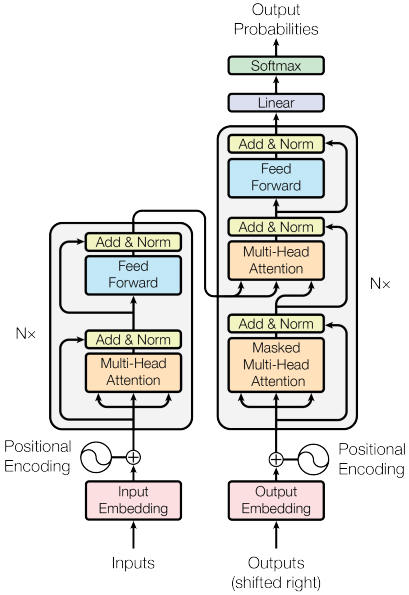

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

Recurrent neural networks are very slow to train and without LSTM the model is not very accurate. But with LSTM, the model makes it much slower to train.

First for out baseline model we used seq2seq as our baseline model but since doesn't do parallel computing and no GPU is used we have switched to transformer model which is much faster than the seq2seq model 

In the seq2seq model the words are passed to the encoder sequentially and there is no use of GPU there. So in order to do parallel computing for the language translation we went with transformers.


First the tokens are passed through the standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a positional embedding layer. The next function after the Enbedder is the PositionEncoder.

In [143]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        # print("inside embedder init")
        super(Embedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        # print("inside embedder forward")
        return self.embed(x)

As mentioned above Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. We have used the formula (PE(pos,2i)=sin(pos100002i/dmodel), PE(pos,2i+1)=cos(pos100002i/dmodel). with dmodel=512) for Positional Encoder from the following reference. 

http://nlp.seas.harvard.edu/2018/04/03/attention.html



In [144]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        # print("inside PositionalEncoder init")
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # print("inside PositionalEncoder forward")
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], \
        requires_grad=False).to(device)
        # print(x)
        return x

The input mask, input_msk, is simply the same shape as the input sentence but has a value of 1 when the token in the source sentence is not a <pad> token and 0 when it is a <pad> token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to <pad> tokens, which contain no useful information.

In [145]:
def create_masks(input_seq, target_seq):
    # print("inside create_masks")
    input_pad = JA_TEXT.vocab.stoi['<pad>']
    # creates mask with 0s wherever there is padding in the input
    input_msk = (input_seq != input_pad).unsqueeze(1)
    
    target_pad = EN_TEXT.vocab.stoi['<pad>']
    target_msk = (target_seq != target_pad).unsqueeze(1)
    size = target_seq.size(1) # get seq_len for matrix
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype(np.uint8)
    nopeak_mask = torch.autograd.Variable(torch.from_numpy(nopeak_mask) == 0).to(device)
    target_msk = target_msk & nopeak_mask
    
    # print(input_msk)
    # print(target_msk)
    return input_msk, target_msk

We first pass the input sentence and its mask into the multi-head attention layer, then perform dropout on it,  pass it through a Layer Normalization layer. 

The mutli head attention layer is used by the encoder layer to attend to the input sentence, i.e. it is calculating and applying attention over itself instead of another sequence.

Multi head attention means many attention vectors will be created for each word and the Wz weight will choose which attention vector to take. (Multiple attention vector for one word)
And the rest of the things in the Attention model are normal like Feed Forward Neural Network.


In [146]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        # print("inside MultiHeadAttention __init__")
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # print("inside MultiHeadAttention forward")
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        # print(output)
        return output

In [147]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    # print("inside attention")
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    # print(scores)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    # print(output)
    return output

In [148]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        # print("inside FeedForward init")
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) 
    def forward(self, x):
        # print("inside FeedForward forward")
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        # print(x)
        return x

In [149]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        # print("inside Norm init")
        super().__init__()a
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        # print("inside Norm forward")
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        # print(norm)
        return norm

The objective of the decoder is to take the encoded representation of the source sentence and convert it into predicted tokens in the target sentence. We then compare  with the actual tokens in the target sentence to calculate our loss, which will be used to calculate the gradients of our parameters and then use Adam optimizer to update our weights in order to improve our predictions.

In [150]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        # print("inside EncoderLayer init")
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # print("inside EncoderLayer forward")
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        # print("inside EncoderLayer forward : "+x)
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        # print("inside EncoderLayer __init__")
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).to(device)

    def forward(self, x, e_outputs, src_mask, trg_mask):
            # print("inside EncoderLayer forward")
            x2 = self.norm_1(x)
            x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
            x2 = self.norm_2(x)
            x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
            src_mask))
            x2 = self.norm_3(x)
            x = x + self.dropout_3(self.ff(x2))
            # print(x)
            return x

# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

The decoder is similar to encoder, however it has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

In [151]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        # print("inside Encoder __init__")
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        # print("inside Encoder forward")
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        # print("inside Decoder __init__")
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        # print("inside Decoder forward")
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

The main Transformer model code

In [152]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        # print("inside Transformer __init__")
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        # print("inside Transformer forward")
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [153]:
src_vocab = len(JA_TEXT.vocab)
trg_vocab = len(EN_TEXT.vocab)
# print(JA_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, D_MODEL, N, HEADS)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [154]:
input_pad = JA_TEXT.vocab.stoi['<pad>']
target_pad = EN_TEXT.vocab.stoi['<pad>']  

In [155]:
MultiHeadAttention(HEADS, D_MODEL)

MultiHeadAttention(
  (q_linear): Linear(in_features=512, out_features=512, bias=True)
  (v_linear): Linear(in_features=512, out_features=512, bias=True)
  (k_linear): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=512, out_features=512, bias=True)
)

In [156]:
def train_model(model, epochs, print_every=50):
    
    model.train()
    
    start = datetime.now()
    temp = start
    
    total_loss = 0
    
    for epoch in range(epochs):
       
        for i, batch in enumerate(train_iter):
            src = batch.Japanese.transpose(0, 1)
            trg = batch.English.transpose(0, 1)
            # the French sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input = trg[:, :-1]
            
            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(
                preds.view(-1, preds.size(-1)),
                targets,
                ignore_index=target_pad
            )
            loss.backward()
            optim.step()
            
            total_loss += loss.item()
            Loss_hist = []
            Perplexity_hist = []
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                perplexity  = math.exp(loss_avg)
                print("time = {}, epoch {}, iter = {}, loss = {}, perplexity = {}, {} per {} iters".format(
                    (datetime.now() - start) // 60,
                    epoch + 1,
                    i + 1,
                    loss_avg,
                    perplexity,
                    datetime.now() - temp,
                    print_every
                ))
                if i+1 == 450:
                    Loss_hist.append(loss_avg)
                    Perplexity_hist.append(perplexity)
                total_loss = 0
                temp = datetime.now()
    
        print()

In [157]:
model.to(device)
train_model(model, EPOCHS)

time = 0:00:00.155824, epoch 1, iter = 50, loss = 9.019476728439331, perplexity = 8262.452443495316, 0:00:09.349480 per 50 iters
time = 0:00:00.307910, epoch 1, iter = 100, loss = 7.144762582778931, perplexity = 1267.4503749414623, 0:00:09.125011 per 50 iters
time = 0:00:00.462090, epoch 1, iter = 150, loss = 6.4894912147521975, perplexity = 658.1884014617085, 0:00:09.250696 per 50 iters
time = 0:00:00.616094, epoch 1, iter = 200, loss = 6.222094306945801, perplexity = 503.7571501195155, 0:00:09.240153 per 50 iters
time = 0:00:00.770128, epoch 1, iter = 250, loss = 5.900127840042114, perplexity = 365.08413725363874, 0:00:09.241872 per 50 iters
time = 0:00:00.927535, epoch 1, iter = 300, loss = 5.763546733856201, perplexity = 318.47587735535876, 0:00:09.444334 per 50 iters
time = 0:00:01.085078, epoch 1, iter = 350, loss = 5.6538427734375, perplexity = 285.3860352615269, 0:00:09.452427 per 50 iters
time = 0:00:01.242211, epoch 1, iter = 400, loss = 5.645571060180664, perplexity = 283.03

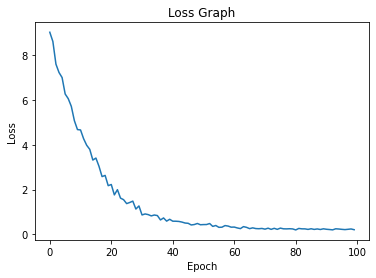

In [3]:
epoch = list(range(100))
import matplotlib.pyplot as plt
plt.plot(epoch,Loss_hist)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() 

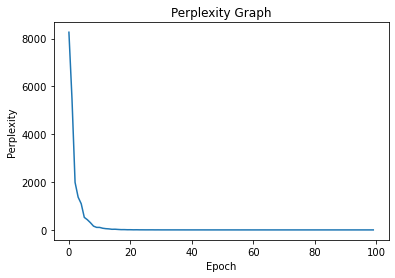

In [4]:
plt.plot(epoch ,Perplexity_hist)
plt.title('Perplexity Graph')
plt.xlabel('Epoch')
plt.ylabel('Perplexity') 
plt.show() 

In [158]:
def translate(model, src, max_len=80, custom_sentence=False):
    
    model.eval()
    
    if custom_sentence == True:
        src = tokenize_ja(src)
        src = torch.autograd.Variable(torch.LongTensor([[JA_TEXT.vocab.stoi[tok] for tok in src]])).to(device)
    
    src_mask = (src != input_pad).unsqueeze(-2)
    e_outputs = model.encoder(src, src_mask)

    outputs = torch.zeros(max_len).type_as(src.data)
    outputs[0] = torch.LongTensor([EN_TEXT.vocab.stoi['<sos>']])
    
    for i in range(1, max_len):    
        trg_mask = np.triu(np.ones((1, i, i)), k=1).astype('uint8')
        trg_mask = torch.autograd.Variable(torch.from_numpy(trg_mask) == 0).to(device)

        out = model.out(
            model.decoder(
                outputs[:i].unsqueeze(0),
                e_outputs,
                src_mask,
                trg_mask
            )
        )
        out = F.softmax(out, dim=-1)
        val, ix = out[:, -1].data.topk(1)

        outputs[i] = ix[0][0]
        if ix[0][0] == EN_TEXT.vocab.stoi['<eos>']:
            break

    return ' '.join([EN_TEXT.vocab.itos[ix] for ix in outputs[:i]])

# **Results and Analysis**

We tried translating 8 sentences using our model and our analysis are as mentioned below.

The below sentence translated correctly from Japanese to English. One thing to note here is we have not added "end of the sentence dot". Even though we have not added the sentence got predicted correctly as there was a subject "I" (僕).

In [ ]:
translate(model, '僕は駅に行く途中なの', custom_sentence=True) 

"<sos> I 'm on my way to the station ."

The below is the same sentence that we tried without giving the subject "I" (僕). And the results are correct. 

In [ ]:
translate(model, '駅に行く途中なの。', custom_sentence=True) 

"<sos> I 'm on my way to the station ."

The below sentence was an interesting case. Here we didnt give the subject "I"(僕) and didnt end the sentence with (。) and as we can see the translated is weird. The correct translation is "On the way to the station". So we have analysed that our model predicts fairly if proper end of sentences dot is given or atleast a subject shoud be there.

In [ ]:
translate(model, '駅に行く途中なの', custom_sentence=True) 

'<sos> the way of the station on my way to the station .'

This below sentence is another sample sentece taken from the test file and our model seems to translate it correctly.

In [ ]:
translate(model, '私は彼が医者であるかどうかわからない。', custom_sentence=True) 

"<sos> I do n't know if he 's a doctor ."

The below sentence is also been translated more or less fairly. The correct translation is more like "I am really sorry to interupt".

In [ ]:
translate(model, 'お話し中、申し訳ありません。', custom_sentence=True) 

"<sos> I 'm sorry to have troubled you ."

The below sentence is another interesting case. This sentence translation is actually "Tokyo Olympic Organization Committee" which Google predicts it correctly but our model did not predict it well. This sentence is taken from the first dataset (Kyoto_lexicon) where it dealt only about Japanese cultures, organizations and religion. We think that to predict this sentence more accurately we need more data on that dataset for training.

In [ ]:
translate(model, '東京オリンピック組織委員会。', custom_sentence=True)

'<sos> Tokyo is the failed to leave Japan .'

The below two sentences are some random sentences which was given to model out of curiosity. And our model seems to translate it well.

In [ ]:
translate(model, '日本語は難しいと思います', custom_sentence=True) 

'<sos> I think that Japanese is difficult .'

In [ ]:
translate(model, '英語は簡単です' , custom_sentence=True)

'<sos> English is easy .'

# **BLEU Score**

We could achieve a BLEU score of 41.49 for our model for Japanese to English Neural Machine Translation which is equal to the State of the art BLEU score.

In [159]:
test_df = pd.read_csv('test.csv') 

In [160]:
test_df

,Japanese,English
0,睡眠をとったほうがいい。,You need sleep.
1,本ばっかり読んでないで、たまには外で体を動かしてきなさい。,Don't just read books. Go outside once in a wh...
2,達人,a master
3,好事魔多し。,Happy events tend to be accompanied by problems.
4,伊勢神戸藩,Ise-Kanbe Domain
...,...,...
22887,彼女は研究に夢中だ。,She is absorbed in her study.
22888,京阪バス山科営業所,"Yamashina Office, Keihan Bus Co., Ltd."
22889,トムは頭に青いバンダナをしている。,Tom is wearing a blue bandana on his head.
22890,大伴王・長岡王・名草王・山階王・采女王,"Prince Otomo, Prince Nagaoka, Prince Nagusa, P..."


In [161]:
import warnings
warnings.filterwarnings('ignore') 

In [162]:
data_length = len(test_df["English"]);
total_score = 0;

for i in range(data_length):
  # print(i)
  reference = tokenize_en(test_df["English"][i]);
  candidate = tokenize_en(translate(model, test_df["Japanese"][i] , custom_sentence=True));
  candidate = candidate[3:]
  score = sentence_bleu(reference, candidate)
  total_score += score;

# print(total_score/data_length)

In [164]:
print(f'BLEU score = {(total_score/data_length)*100}') 

BLEU score = 41.49447833345196


# REFERENCES

1) https://charon.me/posts/pytorch/pytorch_seq2seq_1/




2) https://github.com/bentrevett/pytorch-seq2seq




3) https://www.guru99.com/seq2seq-model.html




4) https://arxiv.org/pdf/1409.3215.pdf




5) https://www.kaggle.com/phunghieu/transformer-demo/log



6) https://en.wikipedia.org/wiki/Perplexity

    
7) https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=The%20Bilingual%20Evaluation%20Understudy%20Score,in%20a%20score%20of%200.0.
    

8) http://nlp.seas.harvard.edu/2018/04/03/attention.html#batches-and-masking